# What does *self* refer to in the self-attention mechanism?

The term "self-attention" in this mechanism, akin to other attention mechanisms, involves the introduction of weights. However, a crucial distinction lies in how these weights are defined. Before delving into the specifics, let's establish an understanding of what "self" signifies in the context of self-attention. To illustrate this concept, we'll walk through a straightforward example.

Suppose we aim to evaluate a car company's performance by examining the prices of the cars it manufactures over a 10-year period.

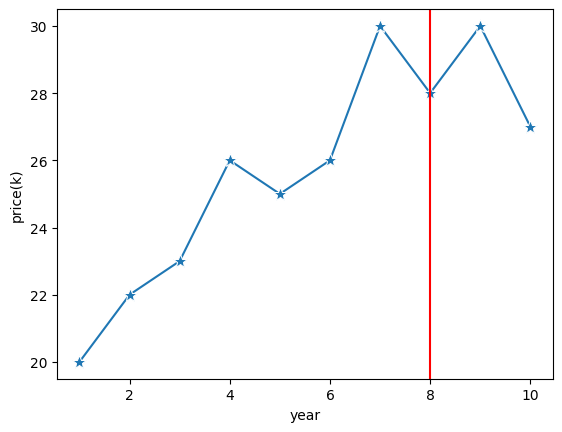

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

year=range(1,11)
price=[20,22,23,26,25,26,30,28,30,27]
price_history = pd.DataFrame(zip(year,price), 
                             columns=['year','price(k)'])
ax=sns.lineplot(x='year', y='price(k)', data=price_history, marker="*", markersize=10)
_=ax.axvline([8], color='red')

Despite an overall upward trend in prices, there is some inherent noise, as evidenced by fluctuations such as a price drop from year 7 to year 8. When assessing the global trend, it becomes beneficial to mitigate this noise. In simpler terms, if our focus is solely on the pricing dynamics in year 8, where a local drop occurs, and we still aim to form a robust evaluation of the company's overall performance, it becomes imperative to disregard the local noise causing the price decrease compared to the previous year.

To achieve this, we can employ a technique to smooth the trend, such as applying a low-pass filter like a moving average. Consider the following low-pass filter, commonly known as an exponential moving average:

$$\hat{y}_{t}= (1-\alpha) \times \hat{y}_{t-1} + \alpha\times y_t $$

At each year $t$, a new representation for the price $y_t$ is computed as $\hat{y}_{t}$, essentially a weighted average of the prices observed up to that point.

Before drawing parallels to the attention mechanism, let's examine the outcome of this filtering:

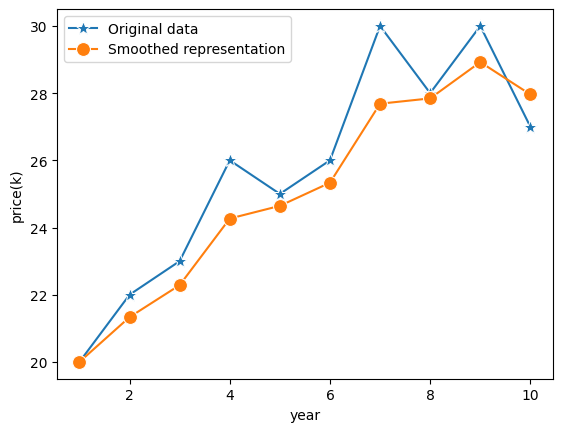

In [2]:
price_history['price_smoothed(k)'] = price_history['price(k)'].ewm(alpha=.5).mean() ## ewm applies the formula above

ax=sns.lineplot(x='year', y='price(k)', data=price_history, marker="*", markersize=10, label='Original data')
_=sns.lineplot(ax=ax, x='year', y='price_smoothed(k)', data=price_history, 
               marker="o", markersize=10, label='Smoothed representation')

What we executed above can also be aptly termed as *attention*. For each observation in the 10-year sample, we compute a new representation by weighing it against other observations. The parameter 
$\alpha$ guides the degree of attention assigned to previous values versus the current one.

In this scenario, we effectively "contextualized" the price with time. In simpler terms, to derive a fresh representation of price each year, we attend to other observed prices contingent on their temporal relationship. The Self-Attention mechanism is intimately linked with contextualization. Consequently, the next segment will furnish a more explicit example of contextualization.

## Adding context

In the earlier example, as elucidated, we contextualized each observation within the 10-year sample with respect to time. Now, let's consider a scenario where each observation is associated with additional contextual information, also referred to as attributes.

Suppose the car company in our example exclusively produces two car models, A and B, and these cars are available in only two colors: black and blue. Let's incorporate this additional information into the price history:

In [3]:
price_history['color']=['black', 'black', 'black','blue', 'black','blue','black','blue','black','blue']
price_history['model']=['A','A','A','A','A','A','B','B','A','B']

With these additional contexts, we now have more factors to consider for assessing performance. To gain insights into how these extra contexts aid in interpreting prices, let's visualize the price trends for each model and color-code them:

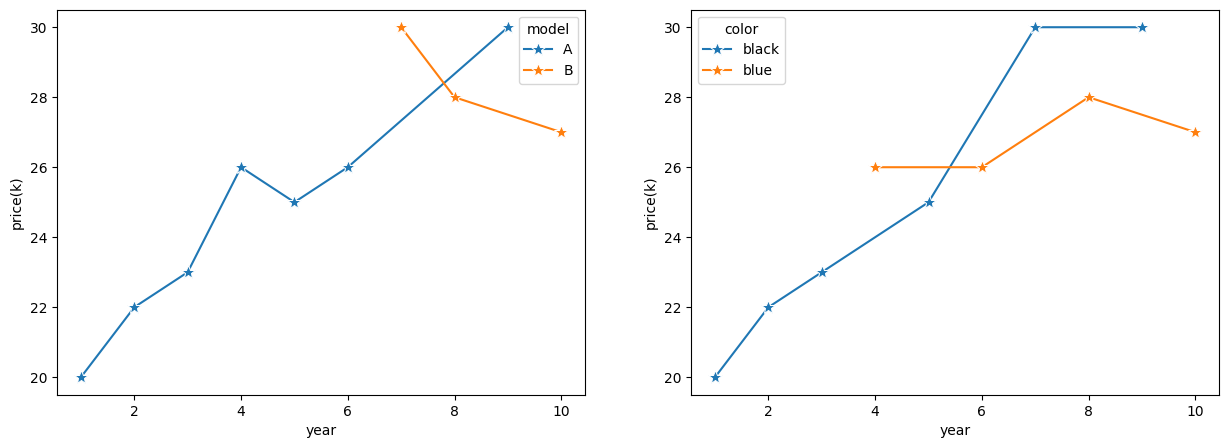

In [4]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
_=sns.lineplot(ax=ax[0], x='year', y='price(k)', data=price_history, hue='model',marker="*", markersize=10)
_=sns.lineplot(ax=ax[1], x='year', y='price(k)', data=price_history, hue='color',marker="*", markersize=10)

### Problem statement

Now equipped with the additional contextual information, we progress by framing a new problem. Let's contemplate a fresh set of price histories spanning a different time period. The objective here is to compare car prices between these two distinct samples.

Text(0.5, 1.0, 'period 1')

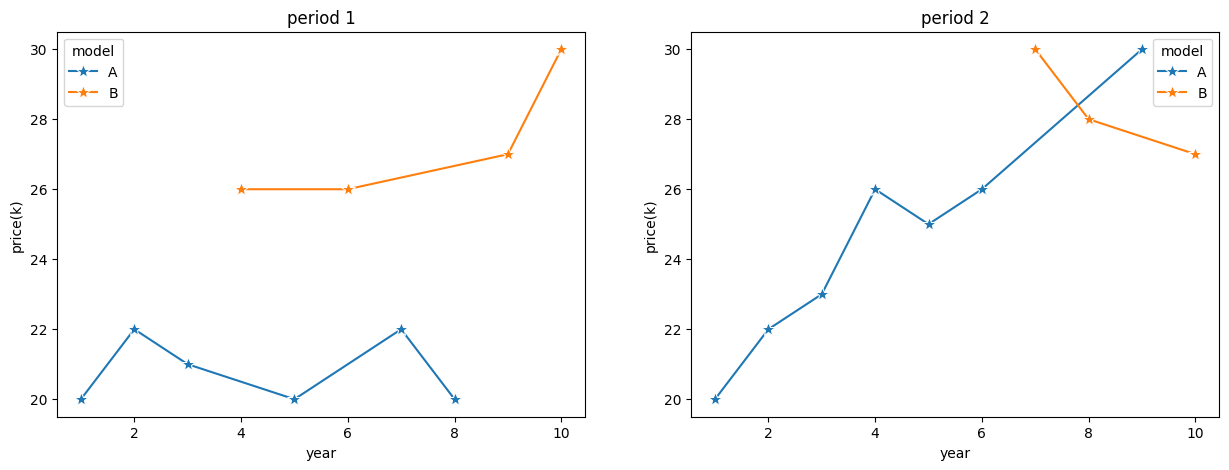

In [5]:
price_history_new = price_history[['year']].copy()
price_history_new['price(k)'] = [20,22,21,26,20,26,22,20,27,30]
price_history_new['color']=['black', 'black', 'black','black', 'black','blue','black','blue','blue','blue']
price_history_new['model']=['A','A','A','B','A','B','A','A','B','B']

fig, ax = plt.subplots(1,2, figsize=(15,5))
_=sns.lineplot(ax=ax[0], x='year', y='price(k)', data=price_history_new, hue='model',marker="*", markersize=10)
_=sns.lineplot(ax=ax[1], x='year', y='price(k)', data=price_history, hue='model',marker="*", markersize=10)
ax[1].set_title('period 2'); ax[0].set_title('period 1')

The trends already exhibit notable differences, but let's focus on the initial price observations at year 1 in both samples. Both pertain to model A and carry the same price tag of 20K. However, they evidently hold distinct meanings or contributions in the two time periods. In period 1, the 20K price for model A aligns closely with the average price for this model during that time, whereas in period 2, it stands as the lowest recorded price for car model A. Thus, despite being the same model with identical prices, they warrant different interpretations. To underscore this disparity, leveraging context information can facilitate the derivation of a more meaningful representation.

### New representation based on the context

Initially, we must convert the contextual information into a numerical representation. To achieve this, let's employ one-hot encoding:

In [46]:
price_history_ohe = pd.get_dummies(price_history)
price_history_new_ohe = pd.get_dummies(price_history_new)

price_history_ohe.head()

,year,price(k),price_smoothed(k),new_price(k),model_A,model_B,color_black,color_blue
0,1,20,20.000000,24.571429,True,False,True,False
1,2,22,21.333333,24.571429,True,False,True,False
2,3,23,22.285714,24.571429,True,False,True,False
3,4,26,24.266667,24.571429,True,False,False,True
4,5,25,24.645161,24.571429,True,False,True,False


Moving forward, to integrate context into the price representation, we adhere to a weighted averaging approach. Distinct from before, the weights are now determined by the similarity of cars based on their model and color. Thus, the initial step involves defining a similarity score:

#### Similarity score

One way to measure similarity between two numerical vectors is dot product. For a 10-year period the car price is represented by a vector $y$ of length four (to contain model and color information):

$$y_{1},..., y_{10}$$

Similarly, we consider context vector as:
$$c_{1},..., c_{10}$$

where $c_{t}$ represents the context vector for the car at year $t$.
Now, we can utilize the dot product on the context information between the cars in our sample set. For each pair of cars at year $m,n$, the similarity score is:
$$similarity\_score(c_{m},c_{n}) = c_{n}\cdot c_{m} $$

It is very useful to normalize the similarity score. Thus, we take the normalized version of dot product by mapping the values between 0 and 1:

$$ w_{m,n} = (c_{n}\cdot c_{m}) / \sum_{i,j=1}^{10} (c_{i}\cdot c_{j})$$

So we could use $w_{m,n}$ as the measure of similarity.


### New representation with weighted averaging

Let's rememeber what the end goal is: we want to incorporate more information (context info like color and model) to interpret the prices. In other words, a new price representation is based on the context info. Thus, the ultimate goal is still as follows:
$$\hat{y}_{t} = f(y_t)$$
where through $f$ we find the new representation. We consider $f$ to be a reweighing process.

In the previous section we argued how the similarity based on context info could be helpful. For each year $q$, we do the following:


$\hspace{7cm} c_q \xrightarrow{\text{dot product}}  [c_{1}, ..., c_{k}, ... , c_{10}] \xrightarrow{\text{normalizing}} [w_{1,q},...,w_{k,q},...,w_{10,q}]$
                                    
We intentionally used $q$ as index to start with introducing the term *query*, which is a common term you face a lot in the context of self-attention. 

**So, the data from each year *queries* other context data (which is called *KEYS* from database analogy) what the similarity scores would be**.

Then, to find a new representation $\hat{y}_{q}$ we calculate the weighted average of the original price (which is called *VALUES*):

$$\hat{y}_{q} = w_{1,q}y_{1}+...+w_{k,q}y_{k}+...+w_{10,q}y_{10}$$


*If we consider the 10-year price info as one sample, what we just did is that each component of the sample attends to other components of the **same** sample to make a new representation. You might now have a glimpse of why we use the term **self**. Each sample attends to itself to get it's new representation.*

Let's apply the model context info to make a new price representation, below we only consider the car model as context:

In [1]:
from src.self_attention.utils import weighted_average

context_columns=['model_A','model_B']
value_column='price(k)'
price_history['new_price(k)'] = weighted_average(price_history_ohe, context_columns, value_column)
price_history_new['new_price(k)'] = weighted_average(price_history_new_ohe, context_columns, value_column)

fig, ax = plt.subplots(2,2, figsize=(15,10))
_=sns.lineplot(ax=ax[0,0], x='year', y='price(k)', data=price_history_new, hue='model', marker="*", markersize=10)
_=sns.lineplot(ax=ax[0,1], x='year', y='new_price(k)', data=price_history_new, hue='model', marker="*", markersize=10)
_=sns.lineplot(ax=ax[1,0], x='year', y='price(k)', data=price_history, hue='model', marker="*", markersize=10)
_=sns.lineplot(ax=ax[1,1], x='year', y='new_price(k)', data=price_history, hue='model', marker="*", markersize=10)

NameError: name 'price_history_ohe' is not defined

The new price representation is smoothed out based on car models. Noting to the first observations of the car price in the twp periods, now we see they are not equal any more.

In [23]:
price_history_ohe['similarity_with_year7']=0
context_only = price_history_ohe[['color_black','color_blue','model_A','model_B']]
context_only_year_7 = context_only.iloc[7,:]
for row_index, row_value in context_only.iterrows():
    price_history_ohe.loc[row_index,'similarity_with_year7'] = row_value.dot(context_only_year_7)
price_history_ohe

C:\Users\rsahraei\AppData\Local\Temp\ipykernel_5148\3315323039.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  price_history_ohe.loc[row_index,'similarity_with_year7'] = row_value.dot(context_only_year_7)


,year,price(k),price_smoothed(k),color_black,color_blue,model_A,model_B,similarity_with_year7
0,1,20,20.000000,True,False,True,False,False
1,2,22,21.333333,True,False,True,False,False
2,3,23,22.285714,True,False,True,False,False
3,4,26,24.266667,False,True,True,False,True
4,5,25,24.645161,True,False,True,False,False
5,6,26,25.333333,False,True,True,False,True
6,7,30,27.685039,True,False,False,True,True
7,8,28,27.843137,False,True,False,True,True
8,9,30,28.923679,True,False,True,False,False
9,10,27,27.960899,False,True,False,True,True
